In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [4]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [5]:
train.shape, test.shape

((8523, 12), (5681, 11))

In [6]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [8]:
#Check for duplicates between train and test
print('Unique IDs in train:', train['Item_Identifier'].nunique())
print('Unique IDs in test:', test['Item_Identifier'].nunique())

Unique IDs in train: 1559
Unique IDs in test: 1543


In [9]:
unique_train_id=set(train['Item_Identifier'])
unique_test_id=set(test['Item_Identifier'])

len(unique_test_id.intersection(unique_train_id))

1543

In [10]:
nan_features_train=[feature for feature in train.columns if train[feature].isnull().sum()>1]
nan_features_train

['Item_Weight', 'Outlet_Size']

In [11]:
nan_features_test=[feature for feature in test.columns if test[feature].isnull().sum()>1]
nan_features_test

['Item_Weight', 'Outlet_Size']

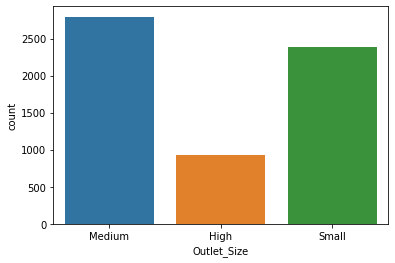

In [12]:
sns.countplot(train['Outlet_Size'])

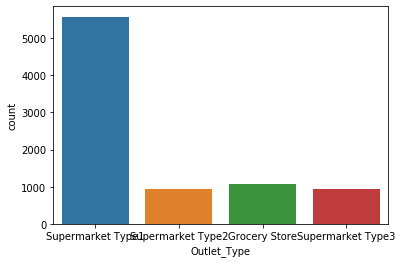

In [13]:
sns.countplot(train['Outlet_Type'])

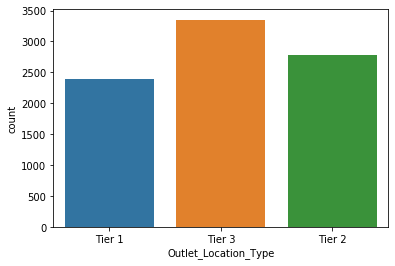

In [14]:
sns.countplot(train['Outlet_Location_Type'])

In [15]:
pd.crosstab(train['Outlet_Size'], train['Outlet_Type'])

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,,,,
High,0,932,0,0
Medium,0,930,928,935
Small,528,1860,0,0


In [16]:
pd.crosstab(train['Outlet_Size'], train['Outlet_Location_Type'])

Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Size,,,
High,0,0,932
Medium,930,0,1863
Small,1458,930,0


In [17]:
pd.crosstab(train['Outlet_Type'], train['Outlet_Location_Type'])

Outlet_Location_Type,Tier 1,Tier 2,Tier 3
Outlet_Type,,,
Grocery Store,528,0,555
Supermarket Type1,1860,2785,932
Supermarket Type2,0,0,928
Supermarket Type3,0,0,935


In [18]:
train['Outlet_Size'].value_counts(dropna=False)

Medium    2793
NaN       2410
Small     2388
High       932
Name: Outlet_Size, dtype: int64

In [19]:
train['Item_Weight'].mean()

12.857645184136183

In [20]:
# Filling NaN 
train['Item_Weight']=train['Item_Weight'].fillna(12)
train['Outlet_Size']=train['Outlet_Size'].fillna('Small')

test['Item_Weight']=test['Item_Weight'].fillna(12)
test['Outlet_Size']=test['Outlet_Size'].fillna('Small')

In [21]:
train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [22]:
obj_features_train=[feature for feature in train.columns if train[feature].dtypes=='O']
obj_features_train

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [23]:
obj_features_test=[feature for feature in test.columns if test[feature].dtypes=='O']
obj_features_test

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [24]:
train[obj_features_train].apply(lambda x:len(x.unique()))

Item_Identifier         1559
Item_Fat_Content           5
Item_Type                 16
Outlet_Identifier         10
Outlet_Size                3
Outlet_Location_Type       3
Outlet_Type                4
dtype: int64

In [25]:
# Print frequencies of these categories
for col in obj_features_train:
    print('Value counts for', col)
    print(train[col].value_counts())
    print('\n')

Value counts for Item_Identifier
FDG33    10
FDW13    10
NCI54     9
FDV60     9
NCQ06     9
         ..
FDY43     1
FDQ60     1
FDT35     1
FDK57     1
FDN52     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value counts for Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value counts for Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value counts for Outlet_Identifier
OUT027    935
OUT013    932
OUT046    930
OUT049    930


In [26]:
# Print frequencies of categories in test data
for col in obj_features_test:
    print('Value counts for', col)
    print(test[col].value_counts())
    print('\n')

Value counts for Item_Identifier
FDQ60    8
FDN52    8
FDK57    8
FDZ50    8
DRF48    8
        ..
FDU25    1
FDU12    1
FDF04    1
NCB18    1
FDG38    1
Name: Item_Identifier, Length: 1543, dtype: int64


Value counts for Item_Fat_Content
Low Fat    3396
Regular    1935
LF          206
reg          78
low fat      66
Name: Item_Fat_Content, dtype: int64


Value counts for Item_Type
Snack Foods              789
Fruits and Vegetables    781
Household                638
Frozen Foods             570
Dairy                    454
Baking Goods             438
Canned                   435
Health and Hygiene       338
Meat                     311
Soft Drinks              281
Breads                   165
Hard Drinks              148
Starchy Foods            121
Others                   111
Breakfast                 76
Seafood                   25
Name: Item_Type, dtype: int64


Value counts for Outlet_Identifier
OUT027    624
OUT013    621
OUT046    620
OUT049    620
OUT035    620
OUT045    619

In [27]:
# Correcting the labels for 'Item_Fat_Content'
train['Item_Fat_Content']=train['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                             'reg':'Regular',
                                                             'low fat':'Low Fat'})

test['Item_Fat_Content']=test['Item_Fat_Content'].replace({'LF':'Low Fat',
                                                            'reg':'Regular',
                                                            'low fat':'Low Fat'})

In [28]:
# Making a new feature from 'Item_Identifier'
train['Item_Type_Combined']=train['Item_Identifier'].apply(lambda x: x[0:2])
test['Item_Type_Combined']=test['Item_Identifier'].apply(lambda x: x[0:2])

#Rename them to more intuitive categories:
train['Item_Type_Combined']=train['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})
test['Item_Type_Combined']=test['Item_Type_Combined'].map({'FD':'Food',
                                                             'NC':'Non-Consumable',
                                                             'DR':'Drinks'})

In [29]:
# Making a new feature from 'Outlet_Establishment_Year'

train['Age_of_outlet']=2020-train['Outlet_Establishment_Year']
test['Age_of_outlet']=2020-test['Outlet_Establishment_Year']

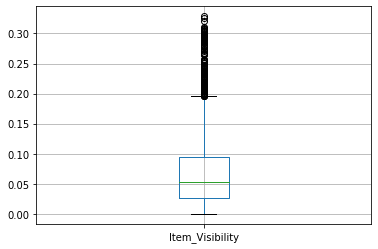

In [30]:
train.boxplot(column='Item_Visibility')

In [31]:
# delete the observations

Q1 = train['Item_Visibility'].quantile(0.25)
Q3 = train['Item_Visibility'].quantile(0.75)
IQR = Q3 - Q1
new_train = train.query('(@Q1 - 1.5 * @IQR) <= Item_Visibility <= (@Q3 + 1.5 * @IQR)')

In [32]:
new_train.shape, train.shape

((8379, 14), (8523, 14))

In [33]:
train=new_train

In [34]:
train['Item_Visibility'].mean()

0.0630612878336319

In [35]:
# Replacing the 0 item_visibility with the mean item_visibility

train.loc[train['Item_Visibility']==0,'Item_Visibility']=train['Item_Visibility'].mean()
test.loc[test['Item_Visibility']==0,'Item_Visibility']=train['Item_Visibility'].mean()

In [36]:
# Making a new feature from 'Item_Visibility'

Mean_Visibility=train['Item_Visibility'].mean()

train['Item_Visibility_MeanRatio']=train.apply(lambda x:x['Item_Visibility']/Mean_Visibility,axis=1)
test['Item_Visibility_MeanRatio']=test.apply(lambda x:x['Item_Visibility']/Mean_Visibility,axis=1)

In [37]:
# Making a new feature from 'Item_Visibility'

train['Item_Visibility_bins'] = pd.cut(train['Item_Visibility'], [0.000, 0.065, 0.13, 0.2], 
                                       labels=['Low Viz', 'Viz', 'High Viz'])
train['Item_Visibility_bins'] = train['Item_Visibility_bins'].fillna('Low Viz')

test['Item_Visibility_bins'] = pd.cut(test['Item_Visibility'], [0.000, 0.065, 0.13, 0.2], 
                                       labels=['Low Viz', 'Viz', 'High Viz'])
test['Item_Visibility_bins'] = test['Item_Visibility_bins'].fillna('Low Viz')

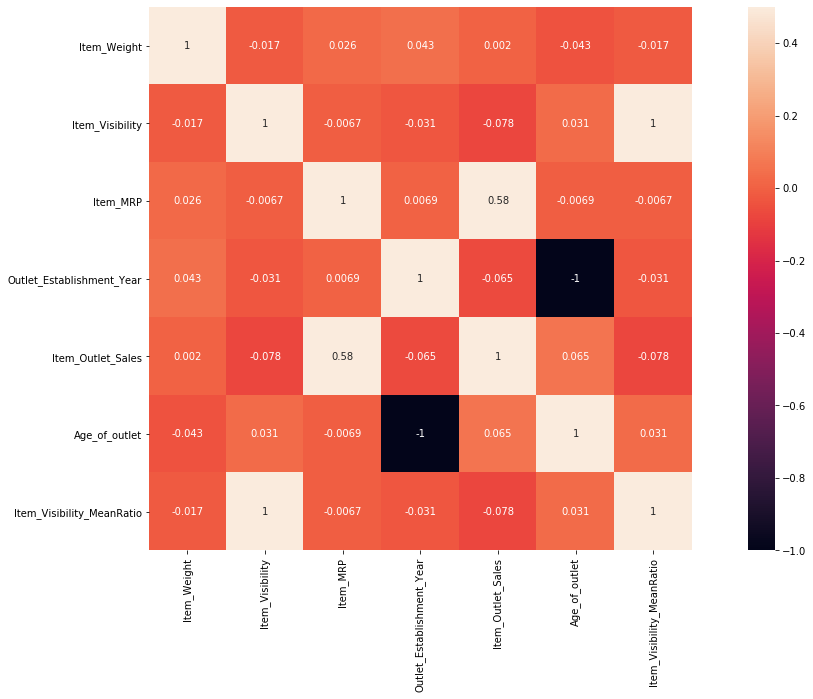

In [38]:
correl=train.corr()
plt.figure(figsize=(20,10))
sns.heatmap(correl,annot=True,vmax=0.5,square=True)

In [39]:
train.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales', 'Item_Type_Combined',
       'Age_of_outlet', 'Item_Visibility_MeanRatio', 'Item_Visibility_bins'],
      dtype='object')

In [40]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_Combined,Age_of_outlet,Item_Visibility_MeanRatio,Item_Visibility_bins
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,Food,21,0.239440,Low Viz
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,Drinks,11,0.287649,Low Viz
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,Food,21,0.250076,Low Viz
3,FDX07,19.20,Regular,0.063061,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,Food,22,0.940932,Low Viz
4,NCD19,8.93,Low Fat,0.063061,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,Non-Consumable,33,0.940932,Low Viz


In [41]:
cat_cols=[ 'Item_Fat_Content', 'Item_Type','Outlet_Size','Outlet_Location_Type','Outlet_Type',
          'Item_Type_Combined','Item_Visibility_bins' ]

In [42]:
le = LabelEncoder()

for feat in cat_cols:
    train[feat] = le.fit_transform(train[feat].astype(str))
    test[feat] = le.transform(test[feat].astype(str))

In [43]:
train['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT046    930
OUT049    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    488
OUT019    451
Name: Outlet_Identifier, dtype: int64

In [44]:
train['Outlet_Identifier']=train['Outlet_Identifier'].apply(lambda x: x[4:6])
train['Outlet_Identifier'].value_counts()

27    935
13    932
49    930
35    930
46    930
45    929
18    928
17    926
10    488
19    451
Name: Outlet_Identifier, dtype: int64

In [45]:
test['Outlet_Identifier']=test['Outlet_Identifier'].apply(lambda x: x[4:6])
test['Outlet_Identifier'].value_counts()

27    624
13    621
49    620
35    620
46    620
45    619
18    618
17    617
10    370
19    352
Name: Outlet_Identifier, dtype: int64

In [46]:
train['Outlet_Identifier']=train['Outlet_Identifier'].astype(int)
test['Outlet_Identifier']=test['Outlet_Identifier'].astype(int)

In [47]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Item_Type_Combined,Age_of_outlet,Item_Visibility_MeanRatio,Item_Visibility_bins
0,FDA15,9.30,0,0.016047,4,249.8092,49,1999,1,0,1,3735.1380,1,21,0.239440,1
1,DRC01,5.92,1,0.019278,14,48.2692,18,2009,1,2,2,443.4228,0,11,0.287649,1
2,FDN15,17.50,0,0.016760,10,141.6180,49,1999,1,0,1,2097.2700,1,21,0.250076,1
3,FDX07,19.20,1,0.063061,6,182.0950,10,1998,2,2,0,732.3800,1,22,0.940932,1
4,NCD19,8.93,0,0.063061,9,53.8614,13,1987,0,2,1,994.7052,2,33,0.940932,1


In [48]:
X=train.drop(['Item_Identifier', 'Item_Outlet_Sales'], axis=1)
y=train['Item_Outlet_Sales']

In [49]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8379 entries, 0 to 8522
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8379 non-null   float64
 1   Item_Fat_Content           8379 non-null   int32  
 2   Item_Visibility            8379 non-null   float64
 3   Item_Type                  8379 non-null   int32  
 4   Item_MRP                   8379 non-null   float64
 5   Outlet_Identifier          8379 non-null   int32  
 6   Outlet_Establishment_Year  8379 non-null   int64  
 7   Outlet_Size                8379 non-null   int32  
 8   Outlet_Location_Type       8379 non-null   int32  
 9   Outlet_Type                8379 non-null   int32  
 10  Item_Type_Combined         8379 non-null   int32  
 11  Age_of_outlet              8379 non-null   int64  
 12  Item_Visibility_MeanRatio  8379 non-null   float64
 13  Item_Visibility_bins       8379 non-null   int32

In [50]:
#Train/val split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.33,random_state=42)

In [51]:
X_test=test.drop('Item_Identifier', axis=1)

In [52]:
y_train.head()

5357    5327.0658
855      978.7260
2190     934.7832
3178     801.6232
8323    1842.9344
Name: Item_Outlet_Sales, dtype: float64

# Random Forest

In [53]:
model=RandomForestRegressor(n_estimators=400, max_depth=6, min_samples_leaf=76)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=76,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=400, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [54]:
pred_train=model.predict(X_train)
rmse=sqrt(mean_squared_error(y_train, pred_train))
rmse

1083.8114053896813

In [55]:
pred_val=model.predict(X_val)
rmse=sqrt(mean_squared_error(y_val, pred_val))
rmse

1074.4717254073828

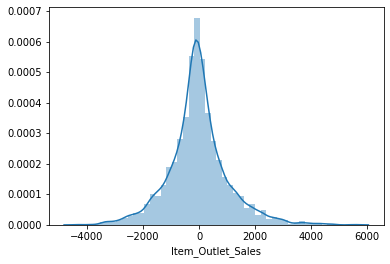

In [56]:
sns.distplot((y_val-pred_val))

In [57]:
pred_test=model.predict(X_test)
pred_test

array([1686.96306019, 1379.07828685,  566.10721728, ..., 1996.37626256,
       3657.38144679, 1342.23980032])

In [58]:
sample=pd.read_csv('sample_submission.csv')
sample.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1000
1,FDW14,OUT017,1000
2,NCN55,OUT010,1000
3,FDQ58,OUT017,1000
4,FDY38,OUT027,1000


In [59]:
test['Outlet_Identifier']='OUT0'+test['Outlet_Identifier'].astype('str')

In [60]:
submission=test[['Item_Identifier', 'Outlet_Identifier']]
submission['Item_Outlet_Sales']=pred_test
submission.head()

,Item_Identifier,Outlet_Identifier,Item_Outlet_Sales
0,FDW58,OUT049,1686.963060
1,FDW14,OUT017,1379.078287
2,NCN55,OUT010,566.107217
3,FDQ58,OUT017,2496.114186
4,FDY38,OUT027,5891.164996


In [61]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Item_Identifier    5681 non-null   object 
 1   Outlet_Identifier  5681 non-null   object 
 2   Item_Outlet_Sales  5681 non-null   float64
dtypes: float64(1), object(2)
memory usage: 133.3+ KB


In [62]:
submission.to_csv('Submission_RF.csv', index=False)